In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
from xgcm import Grid

after running with `THICKNESS_CONFIG = "ISOMIP"`

In [2]:
def make_thickness_file(filename):
    
    ic = xr.open_dataset('MOM_IC.nc')
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()


In [45]:
make_thickness_file('INPUT/thickness_ISOMIPsigmazstar_pdiag.nc')

after running with `THICKNESS_CONFIG = "thickness_file"` and `THICKNESS_FILE = thickness_simpleshelf4.nc` and `#override REMAP_AFTER_INITIALIZATION = False` and 
`#override HACK_MODE = True`

In [3]:
def open_IC():
    IC = xr.open_dataset('MOM_IC.nc')
    return IC


In [4]:
IC = open_IC()
IC.h

<xarray.DataArray 'h' (Time: 1, Layer: 25, lath: 40, lonh: 240)>
[240000 values with dtype=float64]
Coordinates:
  * lath     (lath) float64 1.0 3.0 5.0 7.0 9.0 ... 71.0 73.0 75.0 77.0 79.0
  * lonh     (lonh) float64 321.0 323.0 325.0 327.0 ... 793.0 795.0 797.0 799.0
  * Layer    (Layer) float64 14.4 43.2 72.0 100.8 ... 619.2 648.0 676.8 705.6
  * Time     (Time) timedelta64[ns] 00:00:00
Attributes:
    long_name:  Layer Thickness
    units:      m
    checksum:   EE5AFDB29FEA412D

In [5]:
!pwd

/Users/claireyung/mom6/MOM6-examples/ocean_only/seamount/sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2


In [3]:
ave = False ## True means use 5 daily average rather than hourly prog
basee = '/Users/claireyung/mom6/MOM6-examples/ocean_only/seamount/'
def open_files(folder):
    base = basee + folder
    if ave:
        prog = xr.open_dataset(base + '/ave_prog.nc')
    else:
        prog = xr.open_dataset(base + '/prog.nc')
    ocean_static = xr.open_dataset(base + "/ocean_geometry.nc")
    return prog, ocean_static
def open_IC(folder):
    base = basee + folder
    IC = xr.open_dataset(base + '/MOM_IC.nc')
    return IC
def open_Initialstate(folder):
    base = basee + folder
    IC = xr.open_dataset(base + '/Initial_state.nc')
    return IC

In [4]:
folder = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'
def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap,ymax):
    prog, ocean_static = open_files(label)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[yy0,:], yi) #We repeat the horizontal part of the grid by the number of zlevels
    #cax = ax.contourf(xi,yy[tt,...],dataplot[tt,:,yy0,:],levels = levels, cmap = cmap, extend = 'both',corner_mask = False)
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


New
Old


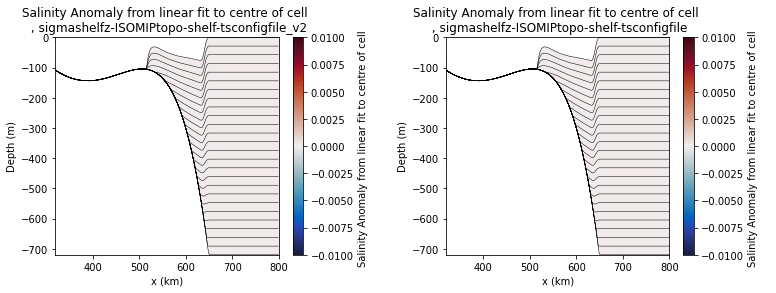

In [46]:
label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'

fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = -1
time = 0
ymax = 720
print('New')
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(axes[0],x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-0.01,0.01,cm.cm.balance,ymax)

print('Old')
label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile'
prog, ocean_static = open_files(label)
IC = open_IC(label)
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(axes[1],x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-0.01,0.01,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)

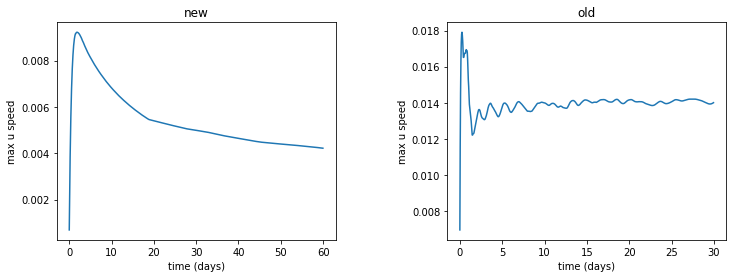

In [47]:
## Plot velocities
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))

label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'
prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[0].set_ylabel('max u speed')
axes[0].set_xlabel('time (days)')
axes[0].set_title('new')

label = 'sigmashelfz-ISOMIPtopo-shelf-og-test'
prog, ocean_static = open_files(label)
axes[1].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[1].set_ylabel('max u speed')
axes[1].set_xlabel('time (days)')
axes[1].set_title('old')

fig.subplots_adjust(wspace = 0.4)

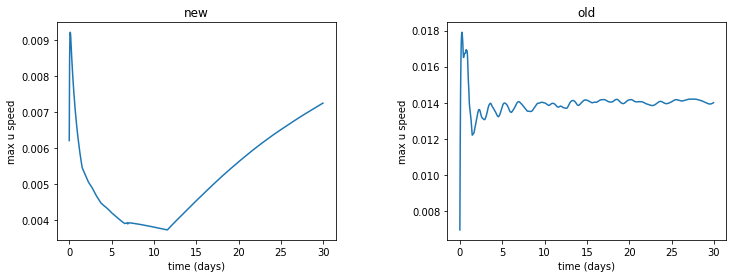

In [5]:
## Plot velocities
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))

label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'
prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[0].set_ylabel('max u speed')
axes[0].set_xlabel('time (days)')
axes[0].set_title('new')

label = 'sigmashelfz-ISOMIPtopo-shelf-og-test'
prog, ocean_static = open_files(label)
axes[1].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[1].set_ylabel('max u speed')
axes[1].set_xlabel('time (days)')
axes[1].set_title('old')

fig.subplots_adjust(wspace = 0.4)

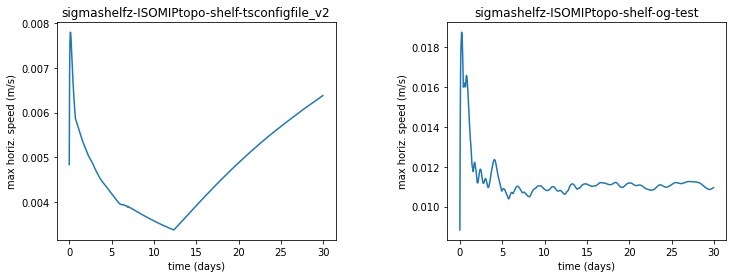

In [7]:
def find_speed(prog):
    # interpolate speeds to the same grid
    uo_interp = grid.interp(prog.u,'x',boundary='extend')
    vo_interp = grid.interp(prog.v,'y',boundary='extend')
    horiz_speed = np.sqrt(uo_interp**2+vo_interp**2)
    return horiz_speed

## Plot speed
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'
prog, ocean_static = open_files(label)
grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)# find horizontal speed
horiz_speed = find_speed(prog)

prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24,horiz_speed.max(['zl','yh','xh']))
axes[0].set_ylabel('max horiz. speed (m/s)')
axes[0].set_xlabel('time (days)')
axes[0].set_title(label)

label = 'sigmashelfz-ISOMIPtopo-shelf-og-test'
prog, ocean_static = open_files(label)
grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)# find horizontal speed
horiz_speed = find_speed(prog)

axes[1].plot(np.arange(len(prog.Time))/24,horiz_speed.max(['zl','yh','xh']))
axes[1].set_ylabel('max horiz. speed (m/s)')
axes[1].set_xlabel('time (days)')
axes[1].set_title(label)

fig.subplots_adjust(wspace = 0.4)

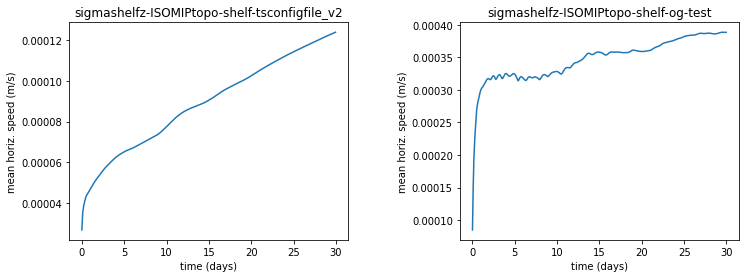

In [15]:
def find_speed(prog):
    # interpolate speeds to the same grid
    uo_interp = grid.interp(prog.u,'x',boundary='extend')
    vo_interp = grid.interp(prog.v,'y',boundary='extend')
    horiz_speed = np.sqrt(uo_interp**2+vo_interp**2)
    return horiz_speed

## Plot speed
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'
prog, ocean_static = open_files(label)
grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)# find horizontal speed
horiz_speed = find_speed(prog)

prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24,horiz_speed.mean(['zl','yh','xh']))
axes[0].set_ylabel('mean horiz. speed (m/s)')
axes[0].set_xlabel('time (days)')
axes[0].set_title(label)

label = 'sigmashelfz-ISOMIPtopo-shelf-og-test'
prog, ocean_static = open_files(label)
grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)# find horizontal speed
horiz_speed = find_speed(prog)

axes[1].plot(np.arange(len(prog.Time))/24,horiz_speed.mean(['zl','yh','xh']))
axes[1].set_ylabel('mean horiz. speed (m/s)')
axes[1].set_xlabel('time (days)')
axes[1].set_title(label)

fig.subplots_adjust(wspace = 0.4)

New


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_32604/3595835953.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)


Old


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_32604/3595835953.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)


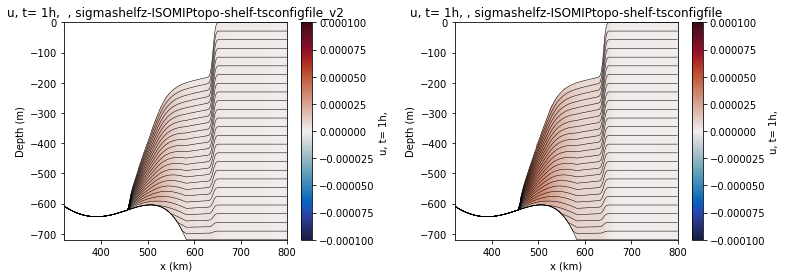

In [14]:
label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'

fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
prog, ocean_static = open_files(label)
x = 20
time = 0
ymax = 720
print('New')
plot(axes[0],x,time,0,prog.u,"u, t= 1h, ",-0.0001,0.0001,cm.cm.balance,ymax)

print('Old')
label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile'
prog, ocean_static = open_files(label)
IC = open_IC(label)
plot(axes[1],x,time,0,prog.u,"u, t= 1h,",-0.0001,0.0001,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)

# try with symmetric shelf

In [17]:
### Make "smooth" version of '/INPUT/Ocean1_3D.nc'
### symmetrized version to be stored in 'filename'
def smoothen_ocean1(filename):
    
    isf = xr.open_dataset("INPUT/Ocean1_3D.nc")
    sli = isf.thick.data[:,:]
    
    new_shelf = nc.Dataset(filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    #print(sli[7,85])
    
    sli[9,70]=(sli[9,69]+sli[9,71])/2  # y = 9
    sli[8,72]=(sli[8,71]+sli[8,73])/2  # y = 8
    sli[6,95]=(sli[6,94]+sli[6,96])/2 # y= 6
    sli[5,97]=(sli[5,96]+sli[5,98])/2 # y= 5
    sli[7,86]=(sli[7,84]+sli[7,88])/2 # y= 7
    sli[7,85]=(sli[7,84]+sli[7,86])/2 # y= 7
    sli[7,87]=(sli[7,86]+sli[7,88])/2 # y= 7
    sli[7,88]=(sli[7,87]+sli[7,89])/2 # y= 7
    
    sli[5,98]=(sli[5,96]+sli[5,100])/2 #y1=5
    sli[5,97]=(sli[5,96]+sli[5,98])/2  #y1=5

    sli[8,73]=sli[8,73]-(sli[8,73]-sli[8,74])/2 # y1=8
    sli[8,72]=(sli[8,71]+sli[8,73])/2 # y1=8
    sli[8,73]=(sli[8,72]+sli[8,74])/2 # y1 =8

    sli[7,87]=(sli[7,86]+sli[7,88])/2 # y1=7
    sli[7,88]=(sli[7,87]+sli[7,89])/2 # y1 =7
    sli[7,87]=(sli[7,85]+sli[7,89])/2 # y1 =7
    sli[7,88]=(sli[7,87]+sli[7,89])/2 # y1 =7
    sli[7,86]=(sli[7,85]+sli[7,87])/2 # y1 = 7

    sli[6,96]=(sli[6,95]+sli[6,97])/2 # y1=6
    sli[6,94]=(sli[6,95]+sli[6,93])/2 # y1 =6

    for jj in [4,3,2]:
        sli[jj,97]=(sli[jj,96]+sli[jj,98])/2 #y1=4
    
    #dat[4,97]=(dat[4,96]+dat[4,98])/2 #y1=3
    #dat[4,97]=(dat[4,96]+dat[4,98])/2 #y1=2

    for jj in [10, 11,12,13,14,15,16,17,18,19]:
        sli[jj,70]=(sli[jj,71]+sli[jj,69])/2 #y1=10
    
    #dat[70]=(dat[71]+dat[69])/2 #y1=11
    #dat[70]=(dat[71]+dat[69])/2 #y1=12
    #dat[70]=(dat[71]+dat[69])/2 #y1=13
    #dat[70]=(dat[71]+dat[69])/2 #y1=14
    #dat[70]=(dat[71]+dat[69])/2 #y1=15
    #dat[70]=(dat[71]+dat[69])/2 #y1=16
    #dat[70]=(dat[71]+dat[69])/2 #y1=17
    #dat[70]=(dat[71]+dat[69])/2 #y1=18
    #dat[70]=(dat[71]+dat[69])/2 #y1=19
    
    new_shelf["thick"][:,:] = sli
    
    #print(sli[7,85])
    
    new_shelf.close()    

In [18]:
### Make symmetric version of ice shelf in_filename
### symmetrized version to be stored in out_filename
def symmetrize_iceshelf(in_filename, out_filename):
    
    isf = xr.open_dataset(in_filename)
    l_thick = isf.thick[:20,:]
    r_thick = np.flip(l_thick, axis=0)
    l_area = isf.area[:20,:]
    r_area = np.flip(l_area, axis=0)

    new_shelf = nc.Dataset(out_filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    new_shelf["area"][:20,:] = l_area.data
    new_shelf["thick"][:20,:] = l_thick.data
    new_shelf["area"][20:,:] = r_area.data
    new_shelf["thick"][20:,:] = r_thick.data

    new_shelf.close()    


In [19]:
smoothen_ocean1('INPUT/tmp.nc')
symmetrize_iceshelf('INPUT/tmp.nc', 'INPUT/symmetric_Ocean1_3D.nc')


In [40]:
make_thickness_file('INPUT/thickness_ISOMIPsigmazstar_pdiag_symmetric1e-4.nc')

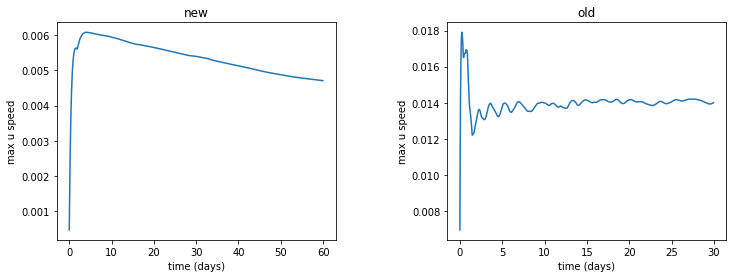

In [41]:
## Plot velocities
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))

label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'
prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[0].set_ylabel('max u speed')
axes[0].set_xlabel('time (days)')
axes[0].set_title('new')

label = 'sigmashelfz-ISOMIPtopo-shelf-og-test'
prog, ocean_static = open_files(label)
axes[1].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[1].set_ylabel('max u speed')
axes[1].set_xlabel('time (days)')
axes[1].set_title('old')

fig.subplots_adjust(wspace = 0.4)

try to reduce pressure on ice?

In [32]:
def make_thinner_ice_file(filename):
    
    ic = xr.open_dataset('MOM_Shelf_IC.nc')
    ice = xr.open_dataset('MOM_IC.nc')
    
    _, lath, lonh = ic.h_shelf.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("lath", lath)
    new_thick.createDimension("lonh", lonh)
    new_thick.createVariable("thick","f8",("lath","lonh"))
    new_thick.createVariable("area","f8",("lath","lonh"))

    new_thick["thick"][:,:] = ice.eta.isel(Time = 0, Interface = 0).data*(-1030/990)
    new_thick["area"][:,:] = ic.shelf_area.data
    
    new_thick.close()


In [33]:
make_thinner_ice_file('INPUT/thinner_Ocean1_3D.nc')

In [34]:
make_thickness_file('INPUT/thickness_ISOMIPsigmazstar_pdiag_thinner.nc')

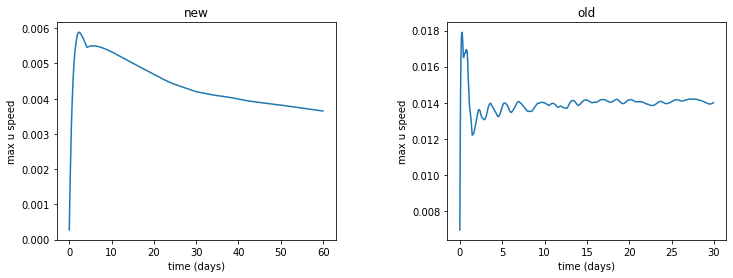

In [35]:
## Plot velocities
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))

label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'
prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[0].set_ylabel('max u speed')
axes[0].set_xlabel('time (days)')
axes[0].set_title('new')

label = 'sigmashelfz-ISOMIPtopo-shelf-og-test'
prog, ocean_static = open_files(label)
axes[1].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[1].set_ylabel('max u speed')
axes[1].set_xlabel('time (days)')
axes[1].set_title('old')

fig.subplots_adjust(wspace = 0.4)

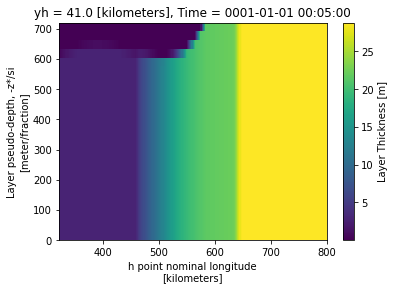

In [39]:
label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'
prog, ocean_static = open_files(label)
prog.h.isel(Time = 0, yh = 20).plot()

min h is 2.77?

# thinner symmetric ice shelf?

In [42]:
make_thinner_ice_file('INPUT/thinner_symmetric_Ocean1_3D.nc')

In [43]:
make_thickness_file('INPUT/thickness_ISOMIPsigmazstar_pdiag_thinner_symmetric.nc')

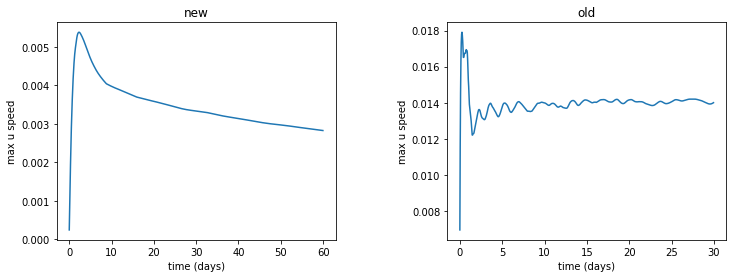

In [44]:
## Plot velocities
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))

label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile_v2'
prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[0].set_ylabel('max u speed')
axes[0].set_xlabel('time (days)')
axes[0].set_title('new')

label = 'sigmashelfz-ISOMIPtopo-shelf-og-test'
prog, ocean_static = open_files(label)
axes[1].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[1].set_ylabel('max u speed')
axes[1].set_xlabel('time (days)')
axes[1].set_title('old')

fig.subplots_adjust(wspace = 0.4)

slightly better. but min h is 2.72m.

also should be 5 days not 60;. timestep is 300s